[link text](https://https://github.com/zoherkh6/zoher_khamaise_ex2.ipynb.git)

Libraries (don't change)

In [ ]:
!pip -q install torchinfo

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


Device (don't change)

In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cpu
Mixed precision (AMP): False


Data (don't change)

In [ ]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [ ]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [ ]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [ ]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [ ]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [ ]:
# =========================
# Step 7 (do change) - 10 RUNS + SAVE TO DRIVE + RESUME
# =========================

!pip -q install openpyxl

import os
import pandas as pd
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ---- Mount Drive (persistent storage) ----
drive.mount('/content/drive')

# ---- Safety check: must run Steps 1-6 first ----
required = ["LayerSpec", "TrainConfig", "ModelConfig", "DataManager", "Trainer", "datasets", "nn", "DEVICE"]
missing = [n for n in required if n not in globals()]
if missing:
    raise RuntimeError(f"Missing: {missing}. Run Steps 1-6 first (especially Step 4).")

# ---- Persistent paths (won't disappear after disconnect) ----
ROOT = "/content/drive/MyDrive/kmnist_data"
os.makedirs(ROOT, exist_ok=True)

excel_path = "/content/drive/MyDrive/kmnist_ex2_results.xlsx"

# ---- Metrics (macro + per-class summary available) ----
def compute_metrics(y_true, y_pred, prefix=""):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(10)), zero_division=0
    )
    out = {
        f"{prefix}accuracy": float(acc),
        f"{prefix}precision_macro": float(pr.mean()),
        f"{prefix}recall_macro": float(rc.mean()),
        f"{prefix}f1_macro": float(f1.mean()),
    }
    return out

# ---- 10 experiments (same family: MLP) ----
experiments = [
    ("exp01", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp02", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.45, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.45, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp03", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.20, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.20, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp04", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=768, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp05", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=128, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp06", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=5e-5),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=5e-5)])),
    ("exp07", dict(lr=1e-3, epochs=35, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=2e-4),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=2e-4)])),
    ("exp08", dict(lr=5e-4, epochs=45, patience=6, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp09", dict(lr=2e-3, epochs=30, patience=4, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
    ("exp10", dict(lr=1e-3, epochs=40, patience=5, batch_size=128,
                   layers=[LayerSpec(out_dim=512, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=256, dropout=0.30, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
                           LayerSpec(out_dim=128, dropout=0.20, batch_norm=True, activation=nn.ReLU, weight_decay=0.0)])),
]

# ---- Load existing Excel (resume support) ----
if os.path.exists(excel_path):
    results_df = pd.read_excel(excel_path)
    done = set(results_df["exp_name"].tolist()) if "exp_name" in results_df.columns else set()
else:
    results_df = pd.DataFrame()
    done = set()

best_trainer = None
best_train_loader = None
best_val_loader = None
best_test_loader = None
best_f1 = -1.0
best_name = None

# If we already have results, initialize best from them
if not results_df.empty and "test_f1_macro" in results_df.columns:
    tmp = results_df.sort_values("test_f1_macro", ascending=False).iloc[0]
    best_f1 = float(tmp["test_f1_macro"])
    best_name = tmp["exp_name"]

# ---- Run all missing experiments (guaranteed 10 total in Excel at the end) ----
for exp_name, cfg in experiments:
    if exp_name in done:
        print(f"✅ Skip {exp_name} (already saved in Excel)")
        continue

    print("\n==============================")
    print("Running:", exp_name)
    print("==============================")

    train_cfg = TrainConfig(
        batch_size=cfg["batch_size"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        patience=cfg["patience"],
        val_fraction=0.1,
        seed=42
    )

    # Load data (saved in Drive so it doesn't re-download every time)
    data_mgr = DataManager(
        dataset_class=datasets.KMNIST,
        root=ROOT,
        val_fraction=train_cfg.val_fraction,
        batch_size=train_cfg.batch_size,
        seed=train_cfg.seed
    )
    train_loader, val_loader, test_loader = data_mgr.get_loaders()

    # Build + train model
    model_cfg = ModelConfig(layers=cfg["layers"])
    model = MLPFromConfig(model_cfg).to(DEVICE)

    trainer_local = Trainer(model, train_cfg)
    trainer_local.fit(train_loader, val_loader)

    # Compute TRAIN + TEST metrics
    preds_tr, targets_tr = trainer_local.predict_all(train_loader)
    preds_te, targets_te = trainer_local.predict_all(test_loader)

    train_m = compute_metrics(targets_tr, preds_tr, prefix="train_")
    test_m  = compute_metrics(targets_te, preds_te, prefix="test_")

    row = {
        "exp_name": exp_name,
        "batch_size": train_cfg.batch_size,
        "epochs": train_cfg.epochs,
        "lr": train_cfg.lr,
        "patience": train_cfg.patience,
        "layers": str([(l.out_dim, l.dropout, l.batch_norm, l.weight_decay) for l in cfg["layers"]]),
    }
    row.update(train_m)
    row.update(test_m)

    # Append + SAVE IMMEDIATELY to Drive (so disconnect won't lose progress)
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
    results_df.to_excel(excel_path, index=False)
    done.add(exp_name)

    print("✅ Saved to Drive Excel:", excel_path)

    # Track best (by test_f1_macro)
    if test_m["test_f1_macro"] > best_f1:
        best_f1 = test_m["test_f1_macro"]
        best_name = exp_name
        best_trainer = trainer_local
        best_train_loader = train_loader
        best_val_loader = val_loader
        best_test_loader = test_loader

# ---- Final: sort and save again ----
results_df = results_df.sort_values("test_f1_macro", ascending=False).reset_index(drop=True)
results_df.to_excel(excel_path, index=False)

print("\n✅ FINAL Excel saved to Drive:", excel_path)
print("✅ Number of experiments in Excel:", len(results_df))
print("🏆 Best experiment (by test_f1_macro):", results_df.loc[0, "exp_name"])

# ---- Ensure Steps 8-9 work: rebuild best trainer if needed ----
# If best_trainer is None (e.g., all 10 were already in Excel), train best once to set `trainer`.
if best_trainer is None:
    best_exp_name = results_df.loc[0, "exp_name"]
    best_cfg = dict(experiments)[best_exp_name]

    train_cfg = TrainConfig(
        batch_size=int(results_df.loc[0, "batch_size"]),
        epochs=int(results_df.loc[0, "epochs"]),
        lr=float(results_df.loc[0, "lr"]),
        patience=int(results_df.loc[0, "patience"]),
        val_fraction=0.1,
        seed=42
    )

    data_mgr = DataManager(
        dataset_class=datasets.KMNIST,
        root=ROOT,
        val_fraction=train_cfg.val_fraction,
        batch_size=train_cfg.batch_size,
        seed=train_cfg.seed
    )
    train_loader, val_loader, test_loader = data_mgr.get_loaders()

    model_cfg = ModelConfig(layers=best_cfg["layers"])
    model = MLPFromConfig(model_cfg).to(DEVICE)

    best_trainer = Trainer(model, train_cfg)
    best_trainer.fit(train_loader, val_loader)

    best_train_loader, best_val_loader, best_test_loader = train_loader, val_loader, test_loader

# Set globals for steps 8-9
trainer = best_trainer
train_loader = best_train_loader
val_loader = best_val_loader
test_loader = best_test_loader

print("\n✅ Ready: trainer / train_loader / val_loader / test_loader are set")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Running: exp01


100%|██████████| 18.2M/18.2M [00:15<00:00, 1.16MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]
100%|██████████| 3.04M/3.04M [00:04<00:00, 734kB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 8.55MB/s]


Train: 54000 | Val: 6000 | Test: 10000
🚀 Starting training...



/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0883 Acc: 0.6874 | Val Loss: 0.6040 Acc: 0.8293
Epoch   2 | Train Loss: 0.5915 Acc: 0.8275 | Val Loss: 0.4446 Acc: 0.8717
Epoch   3 | Train Loss: 0.4778 Acc: 0.8581 | Val Loss: 0.3703 Acc: 0.8923
Epoch   4 | Train Loss: 0.4140 Acc: 0.8766 | Val Loss: 0.3244 Acc: 0.9025
Epoch   5 | Train Loss: 0.3704 Acc: 0.8890 | Val Loss: 0.2921 Acc: 0.9132
Epoch   6 | Train Loss: 0.3342 Acc: 0.8996 | Val Loss: 0.2678 Acc: 0.9195
Epoch   7 | Train Loss: 0.3101 Acc: 0.9065 | Val Loss: 0.2462 Acc: 0.9257
Epoch   8 | Train Loss: 0.2872 Acc: 0.9126 | Val Loss: 0.2306 Acc: 0.9312
Epoch   9 | Train Loss: 0.2700 Acc: 0.9188 | Val Loss: 0.2195 Acc: 0.9357
Epoch  10 | Train Loss: 0.2542 Acc: 0.9229 | Val Loss: 0.2069 Acc: 0.9387
Epoch  11 | Train Loss: 0.2370 Acc: 0.9280 | Val Loss: 0.2000 Acc: 0.9397
Epoch  12 | Train Loss: 0.2256 Acc: 0.9320 | Val Loss: 0.1916 Acc: 0.9433
Epoch  13 | Train Loss: 0.2140 Acc: 0.9346 | Val Loss: 0.1841 Acc: 0.9445
Epoch  14 | Train Loss: 0.2081 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.2204 Acc: 0.6354 | Val Loss: 0.6632 Acc: 0.8140
Epoch   2 | Train Loss: 0.7015 Acc: 0.7885 | Val Loss: 0.4939 Acc: 0.8562
Epoch   3 | Train Loss: 0.5768 Acc: 0.8247 | Val Loss: 0.4164 Acc: 0.8795
Epoch   4 | Train Loss: 0.5129 Acc: 0.8429 | Val Loss: 0.3694 Acc: 0.8903
Epoch   5 | Train Loss: 0.4630 Acc: 0.8579 | Val Loss: 0.3386 Acc: 0.8970
Epoch   6 | Train Loss: 0.4315 Acc: 0.8675 | Val Loss: 0.3139 Acc: 0.9065
Epoch   7 | Train Loss: 0.4043 Acc: 0.8750 | Val Loss: 0.2912 Acc: 0.9117
Epoch   8 | Train Loss: 0.3808 Acc: 0.8833 | Val Loss: 0.2728 Acc: 0.9163
Epoch   9 | Train Loss: 0.3621 Acc: 0.8877 | Val Loss: 0.2603 Acc: 0.9197
Epoch  10 | Train Loss: 0.3434 Acc: 0.8928 | Val Loss: 0.2489 Acc: 0.9255
Epoch  11 | Train Loss: 0.3316 Acc: 0.8979 | Val Loss: 0.2385 Acc: 0.9273
Epoch  12 | Train Loss: 0.3134 Acc: 0.9026 | Val Loss: 0.2283 Acc: 0.9313
Epoch  13 | Train Loss: 0.3064 Acc: 0.9047 | Val Loss: 0.2208 Acc: 0.9348
Epoch  14 | Train Loss: 0.2951 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0233 Acc: 0.7135 | Val Loss: 0.5736 Acc: 0.8390
Epoch   2 | Train Loss: 0.5339 Acc: 0.8463 | Val Loss: 0.4189 Acc: 0.8780
Epoch   3 | Train Loss: 0.4231 Acc: 0.8757 | Val Loss: 0.3470 Acc: 0.8985
Epoch   4 | Train Loss: 0.3599 Acc: 0.8933 | Val Loss: 0.3024 Acc: 0.9110
Epoch   5 | Train Loss: 0.3175 Acc: 0.9062 | Val Loss: 0.2701 Acc: 0.9215
Epoch   6 | Train Loss: 0.2846 Acc: 0.9159 | Val Loss: 0.2449 Acc: 0.9282
Epoch   7 | Train Loss: 0.2570 Acc: 0.9248 | Val Loss: 0.2269 Acc: 0.9322
Epoch   8 | Train Loss: 0.2341 Acc: 0.9314 | Val Loss: 0.2142 Acc: 0.9377
Epoch   9 | Train Loss: 0.2178 Acc: 0.9354 | Val Loss: 0.2020 Acc: 0.9408
Epoch  10 | Train Loss: 0.2030 Acc: 0.9398 | Val Loss: 0.1922 Acc: 0.9447
Epoch  11 | Train Loss: 0.1880 Acc: 0.9454 | Val Loss: 0.1823 Acc: 0.9465
Epoch  12 | Train Loss: 0.1750 Acc: 0.9494 | Val Loss: 0.1765 Acc: 0.9465
Epoch  13 | Train Loss: 0.1654 Acc: 0.9522 | Val Loss: 0.1700 Acc: 0.9503
Epoch  14 | Train Loss: 0.1559 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0485 Acc: 0.6985 | Val Loss: 0.5868 Acc: 0.8365
Epoch   2 | Train Loss: 0.5655 Acc: 0.8340 | Val Loss: 0.4314 Acc: 0.8780
Epoch   3 | Train Loss: 0.4533 Acc: 0.8663 | Val Loss: 0.3577 Acc: 0.9007
Epoch   4 | Train Loss: 0.3925 Acc: 0.8829 | Val Loss: 0.3136 Acc: 0.9080
Epoch   5 | Train Loss: 0.3472 Acc: 0.8968 | Val Loss: 0.2829 Acc: 0.9160
Epoch   6 | Train Loss: 0.3169 Acc: 0.9051 | Val Loss: 0.2581 Acc: 0.9232
Epoch   7 | Train Loss: 0.2869 Acc: 0.9138 | Val Loss: 0.2405 Acc: 0.9277
Epoch   8 | Train Loss: 0.2661 Acc: 0.9208 | Val Loss: 0.2225 Acc: 0.9337
Epoch   9 | Train Loss: 0.2502 Acc: 0.9249 | Val Loss: 0.2109 Acc: 0.9370
Epoch  10 | Train Loss: 0.2321 Acc: 0.9296 | Val Loss: 0.2028 Acc: 0.9402
Epoch  11 | Train Loss: 0.2200 Acc: 0.9340 | Val Loss: 0.1925 Acc: 0.9413
Epoch  12 | Train Loss: 0.2066 Acc: 0.9381 | Val Loss: 0.1824 Acc: 0.9453
Epoch  13 | Train Loss: 0.1972 Acc: 0.9411 | Val Loss: 0.1771 Acc: 0.9460
Epoch  14 | Train Loss: 0.1844 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.1806 Acc: 0.6686 | Val Loss: 0.6842 Acc: 0.8205
Epoch   2 | Train Loss: 0.6591 Acc: 0.8144 | Val Loss: 0.4836 Acc: 0.8668
Epoch   3 | Train Loss: 0.5206 Acc: 0.8498 | Val Loss: 0.3967 Acc: 0.8858
Epoch   4 | Train Loss: 0.4516 Acc: 0.8688 | Val Loss: 0.3475 Acc: 0.8995
Epoch   5 | Train Loss: 0.4005 Acc: 0.8825 | Val Loss: 0.3091 Acc: 0.9103
Epoch   6 | Train Loss: 0.3656 Acc: 0.8902 | Val Loss: 0.2826 Acc: 0.9165
Epoch   7 | Train Loss: 0.3361 Acc: 0.9005 | Val Loss: 0.2630 Acc: 0.9205
Epoch   8 | Train Loss: 0.3092 Acc: 0.9080 | Val Loss: 0.2461 Acc: 0.9267
Epoch   9 | Train Loss: 0.2924 Acc: 0.9137 | Val Loss: 0.2310 Acc: 0.9310
Epoch  10 | Train Loss: 0.2738 Acc: 0.9176 | Val Loss: 0.2168 Acc: 0.9362
Epoch  11 | Train Loss: 0.2565 Acc: 0.9239 | Val Loss: 0.2070 Acc: 0.9398
Epoch  12 | Train Loss: 0.2453 Acc: 0.9260 | Val Loss: 0.1981 Acc: 0.9422
Epoch  13 | Train Loss: 0.2343 Acc: 0.9302 | Val Loss: 0.1896 Acc: 0.9452
Epoch  14 | Train Loss: 0.2225 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0845 Acc: 0.6873 | Val Loss: 0.6047 Acc: 0.8277
Epoch   2 | Train Loss: 0.5927 Acc: 0.8257 | Val Loss: 0.4470 Acc: 0.8688
Epoch   3 | Train Loss: 0.4765 Acc: 0.8580 | Val Loss: 0.3727 Acc: 0.8933
Epoch   4 | Train Loss: 0.4152 Acc: 0.8746 | Val Loss: 0.3266 Acc: 0.9067
Epoch   5 | Train Loss: 0.3683 Acc: 0.8894 | Val Loss: 0.2970 Acc: 0.9152
Epoch   6 | Train Loss: 0.3356 Acc: 0.8988 | Val Loss: 0.2712 Acc: 0.9230
Epoch   7 | Train Loss: 0.3100 Acc: 0.9056 | Val Loss: 0.2517 Acc: 0.9263
Epoch   8 | Train Loss: 0.2863 Acc: 0.9136 | Val Loss: 0.2358 Acc: 0.9327
Epoch   9 | Train Loss: 0.2691 Acc: 0.9188 | Val Loss: 0.2233 Acc: 0.9342
Epoch  10 | Train Loss: 0.2559 Acc: 0.9236 | Val Loss: 0.2121 Acc: 0.9382
Epoch  11 | Train Loss: 0.2385 Acc: 0.9276 | Val Loss: 0.2021 Acc: 0.9398
Epoch  12 | Train Loss: 0.2296 Acc: 0.9291 | Val Loss: 0.1965 Acc: 0.9405
Epoch  13 | Train Loss: 0.2167 Acc: 0.9344 | Val Loss: 0.1883 Acc: 0.9442
Epoch  14 | Train Loss: 0.2073 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.0868 Acc: 0.6881 | Val Loss: 0.6090 Acc: 0.8242
Epoch   2 | Train Loss: 0.5949 Acc: 0.8261 | Val Loss: 0.4486 Acc: 0.8655
Epoch   3 | Train Loss: 0.4793 Acc: 0.8566 | Val Loss: 0.3749 Acc: 0.8887
Epoch   4 | Train Loss: 0.4122 Acc: 0.8754 | Val Loss: 0.3278 Acc: 0.9003
Epoch   5 | Train Loss: 0.3680 Acc: 0.8892 | Val Loss: 0.2956 Acc: 0.9110
Epoch   6 | Train Loss: 0.3344 Acc: 0.8990 | Val Loss: 0.2718 Acc: 0.9192
Epoch   7 | Train Loss: 0.3125 Acc: 0.9054 | Val Loss: 0.2499 Acc: 0.9292
Epoch   8 | Train Loss: 0.2847 Acc: 0.9128 | Val Loss: 0.2353 Acc: 0.9308
Epoch   9 | Train Loss: 0.2685 Acc: 0.9198 | Val Loss: 0.2239 Acc: 0.9340
Epoch  10 | Train Loss: 0.2484 Acc: 0.9242 | Val Loss: 0.2120 Acc: 0.9348
Epoch  11 | Train Loss: 0.2385 Acc: 0.9276 | Val Loss: 0.2042 Acc: 0.9392
Epoch  12 | Train Loss: 0.2276 Acc: 0.9318 | Val Loss: 0.1947 Acc: 0.9412
Epoch  13 | Train Loss: 0.2156 Acc: 0.9342 | Val Loss: 0.1879 Acc: 0.9442
Epoch  14 | Train Loss: 0.2050 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.3503 Acc: 0.6169 | Val Loss: 0.8150 Acc: 0.7895
Epoch   2 | Train Loss: 0.7746 Acc: 0.7825 | Val Loss: 0.5966 Acc: 0.8373
Epoch   3 | Train Loss: 0.6259 Acc: 0.8171 | Val Loss: 0.5009 Acc: 0.8588
Epoch   4 | Train Loss: 0.5435 Acc: 0.8402 | Val Loss: 0.4405 Acc: 0.8738
Epoch   5 | Train Loss: 0.4916 Acc: 0.8536 | Val Loss: 0.3999 Acc: 0.8847
Epoch   6 | Train Loss: 0.4493 Acc: 0.8651 | Val Loss: 0.3698 Acc: 0.8928
Epoch   7 | Train Loss: 0.4184 Acc: 0.8747 | Val Loss: 0.3436 Acc: 0.9002
Epoch   8 | Train Loss: 0.3920 Acc: 0.8824 | Val Loss: 0.3229 Acc: 0.9037
Epoch   9 | Train Loss: 0.3700 Acc: 0.8889 | Val Loss: 0.3031 Acc: 0.9093
Epoch  10 | Train Loss: 0.3506 Acc: 0.8951 | Val Loss: 0.2901 Acc: 0.9123
Epoch  11 | Train Loss: 0.3355 Acc: 0.8988 | Val Loss: 0.2772 Acc: 0.9180
Epoch  12 | Train Loss: 0.3214 Acc: 0.9031 | Val Loss: 0.2667 Acc: 0.9203
Epoch  13 | Train Loss: 0.3064 Acc: 0.9077 | Val Loss: 0.2561 Acc: 0.9242
Epoch  14 | Train Loss: 0.2938 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 0.8564 Acc: 0.7492 | Val Loss: 0.4501 Acc: 0.8700
Epoch   2 | Train Loss: 0.4540 Acc: 0.8637 | Val Loss: 0.3267 Acc: 0.9082
Epoch   3 | Train Loss: 0.3586 Acc: 0.8926 | Val Loss: 0.2715 Acc: 0.9197
Epoch   4 | Train Loss: 0.3066 Acc: 0.9068 | Val Loss: 0.2395 Acc: 0.9292
Epoch   5 | Train Loss: 0.2714 Acc: 0.9171 | Val Loss: 0.2148 Acc: 0.9377
Epoch   6 | Train Loss: 0.2440 Acc: 0.9247 | Val Loss: 0.1986 Acc: 0.9418
Epoch   7 | Train Loss: 0.2205 Acc: 0.9326 | Val Loss: 0.1873 Acc: 0.9438
Epoch   8 | Train Loss: 0.2060 Acc: 0.9377 | Val Loss: 0.1759 Acc: 0.9468
Epoch   9 | Train Loss: 0.1909 Acc: 0.9412 | Val Loss: 0.1651 Acc: 0.9495
Epoch  10 | Train Loss: 0.1775 Acc: 0.9451 | Val Loss: 0.1611 Acc: 0.9500
Epoch  11 | Train Loss: 0.1668 Acc: 0.9489 | Val Loss: 0.1543 Acc: 0.9527
Epoch  12 | Train Loss: 0.1583 Acc: 0.9514 | Val Loss: 0.1502 Acc: 0.9523
Epoch  13 | Train Loss: 0.1487 Acc: 0.9537 | Val Loss: 0.1443 Acc: 0.9557
Epoch  14 | Train Loss: 0.1430 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.3240 Acc: 0.6174 | Val Loss: 0.7250 Acc: 0.8063
Epoch   2 | Train Loss: 0.7034 Acc: 0.7996 | Val Loss: 0.4860 Acc: 0.8622
Epoch   3 | Train Loss: 0.5463 Acc: 0.8391 | Val Loss: 0.3867 Acc: 0.8878
Epoch   4 | Train Loss: 0.4575 Acc: 0.8634 | Val Loss: 0.3280 Acc: 0.9025
Epoch   5 | Train Loss: 0.4057 Acc: 0.8772 | Val Loss: 0.2938 Acc: 0.9113
Epoch   6 | Train Loss: 0.3701 Acc: 0.8889 | Val Loss: 0.2638 Acc: 0.9223
Epoch   7 | Train Loss: 0.3426 Acc: 0.8961 | Val Loss: 0.2435 Acc: 0.9257
Epoch   8 | Train Loss: 0.3146 Acc: 0.9035 | Val Loss: 0.2303 Acc: 0.9308
Epoch   9 | Train Loss: 0.2915 Acc: 0.9119 | Val Loss: 0.2125 Acc: 0.9372
Epoch  10 | Train Loss: 0.2804 Acc: 0.9152 | Val Loss: 0.2043 Acc: 0.9400
Epoch  11 | Train Loss: 0.2622 Acc: 0.9198 | Val Loss: 0.1944 Acc: 0.9432
Epoch  12 | Train Loss: 0.2427 Acc: 0.9265 | Val Loss: 0.1900 Acc: 0.9438
Epoch  13 | Train Loss: 0.2344 Acc: 0.9286 | Val Loss: 0.1829 Acc: 0.9453
Epoch  14 | Train Loss: 0.2259 Acc: 0.

Visuazize the train


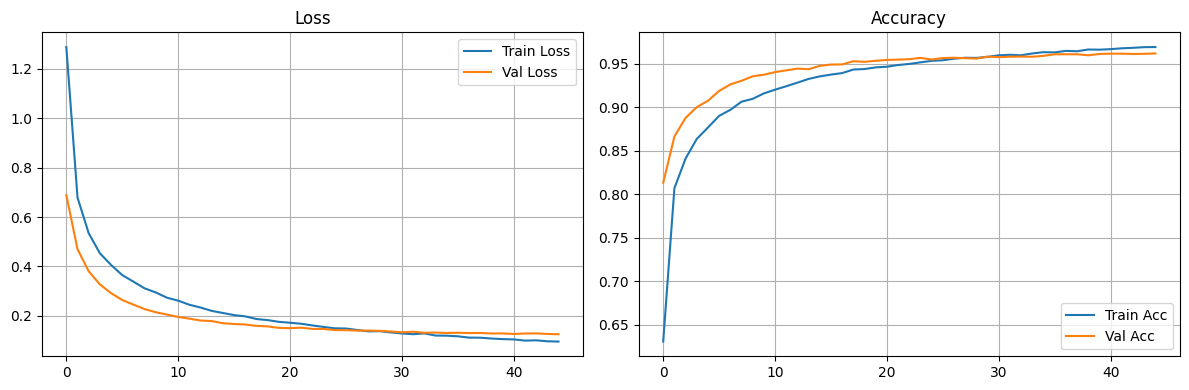

In [ ]:

history = trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




Visualized the test (do change)

/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🧪 Test Loss: 0.3316 | Test Accuracy: 0.9045


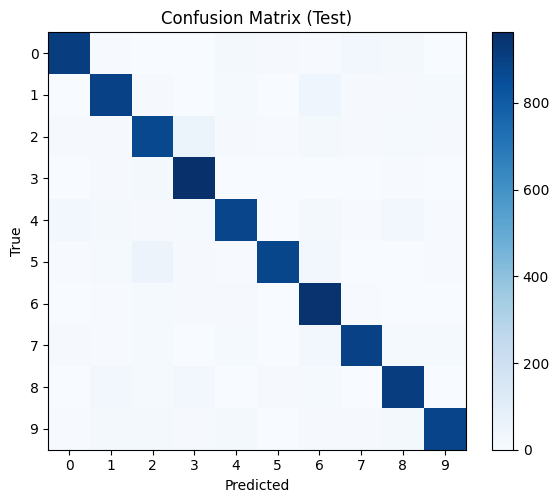

Classification report (Test):
              precision    recall  f1-score   support

           0     0.9372    0.9100    0.9234      1000
           1     0.8943    0.8970    0.8957      1000
           2     0.8491    0.8720    0.8604      1000
           3     0.8925    0.9630    0.9264      1000
           4     0.9030    0.8840    0.8934      1000
           5     0.9638    0.8790    0.9195      1000
           6     0.8510    0.9480    0.8969      1000
           7     0.9286    0.8970    0.9125      1000
           8     0.8990    0.9080    0.9035      1000
           9     0.9446    0.8870    0.9149      1000

    accuracy                         0.9045     10000
   macro avg     0.9063    0.9045    0.9046     10000
weighted avg     0.9063    0.9045    0.9046     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏋️ Train Loss: 0.0199 | Train Accuracy: 0.9952
Classification report (Train):
              precision    recall  f1-score   support

           0     0.9957    0.9967    0.9962      5391
           1     0.9959    0.9970    0.9965      5381
           2     0.9941    0.9926    0.9934      5426
           3     0.9926    0.9981    0.9954      5370
           4     0.9957    0.9934    0.9945      5418
           5     0.9972    0.9871    0.9921      5415
           6     0.9878    0.9957    0.9918      5379
           7     0.9970    0.9980    0.9975      5407
           8     0.9972    0.9967    0.9970      5415
           9     0.9989    0.9970    0.9980      5398

    accuracy                         0.9952     54000
   macro avg     0.9952    0.9952    0.9952     54000
weighted avg     0.9952    0.9952    0.9952     54000



In [ ]:
# ---------------------------
# Step 9 - Test (do change)
# Full evaluation: TEST + TRAIN reports
# ---------------------------

# TEST
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

preds, targets = trainer.predict_all(test_loader)

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
ticks = np.arange(10)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.tight_layout()
plt.show()

print("Classification report (Test):")
print(classification_report(targets, preds, digits=4))

# TRAIN (for overfitting check)
train_loss, train_acc = trainer.evaluate(train_loader)
print(f"🏋️ Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

preds_tr, targets_tr = trainer.predict_all(train_loader)
print("Classification report (Train):")
print(classification_report(targets_tr, preds_tr, digits=4))
